<h1><font color="#113D68" size=5>Redes neuronales convolucionales</font></h1>



<h1><font color="#113D68" size=6>Caso Práctico: análisis de un problema de clasificación de imágenes con Deep Learning</font></h1>


<br><br>
<div style="text-align: right">

<font size=3>Omar Urena</font><br>
<font size=3>Caso Práctico: Redes Neuronales Convolucionales (CNNs)
</font><br>
</div>

---


<a id="indice"></a>
<h2><font color="#004D7F" size=5>Índice</font></h2>

* [Caso práctico](#section1)

* [Flickr Style dataset](#section2)
* [Red convolucional desde 0](#section3)
* [Red pre-entrenada (InceptionV3)](#section4)
* [Red Final](#section5)


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Para mostrar gráficas
import matplotlib.pyplot as plt
%matplotlib inline

# Anaconda fixing problem
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Establecemos una semilla para numpy y tensorflow para poder reproducir la ejecución y los resultados
seed = 101
np.random.seed(seed)
tf.random.set_seed(seed)

<a id="section2"></a>
# <font color="#004D7F" size=5>Flickr Style dataset</font>

Este dataset es un dataset que contiene imágenes en color donde queremos clasificar cada imagen según el estilo fotográfico al que pertenece.

El dataset de de imágenes Flickr Style tiene las siguintes características:
- Imágenes de 5 tipos de estilo: Detailed, Pastel, Melancholy, Noir y HDR.
- Imágenes en color, es decir, cada pixel tiene 3 valores entre 0 y 255, esos valores corresponden a los valores de RGB (Red, Green, Blue).
- Imágenes de diferentes tamaños, por lo que tendremos que redimensionarlas al mismo tamaño todas antes de usarlas en nuestro modelo.
- 2.000 imágenes en total para el entrenamiento y para el test.

In [ ]:
!wget 'https://www.dropbox.com/s/ln92e9givhgzugr/flickr_style.zip?dl=0' -O flickr_style.zip
!unzip -q flickr_style.zip
!mkdir data
!mv flickr_style data/

--2023-05-31 22:30:16--  https://www.dropbox.com/s/ln92e9givhgzugr/flickr_style.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ln92e9givhgzugr/flickr_style.zip [following]
--2023-05-31 22:30:16--  https://www.dropbox.com/s/raw/ln92e9givhgzugr/flickr_style.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbba4a29c653c1e52a46e2febde.dl.dropboxusercontent.com/cd/0/inline/B9HsdFC9fmOiVZ-h3HpZnJjdGdQAcJe5cEZ4OoeYKdwCbB4hngszZn8OOkk3btjsgkEBy-dJmfE7qt4vBcS4L02TOibnmXkT8XuAvM8-pEW59bWDQvnaRSpxo_GaVPPVnJYxnVbSAwNbb1dmBPbASZ0peNw_kkiwqSXMJBxHzFYgGg/file# [following]
--2023-05-31 22:30:17--  https://ucbba4a29c653c1e52a46e2febde.dl.dropboxusercontent.com/cd/0/inline/B9HsdFC9fmOiVZ-h3HpZnJjdGdQAcJe5cEZ4OoeYKdwCbB4hngszZn8OOkk3btj

Vamos a cargar los datos de las labels y los datos de las rutas de las imágenes:

In [ ]:
# obtenemos el nombre de las primeras etiquetas seleccionadas
style_label_file = 'data/flickr_style/style_names.txt'
style_labels = list(np.loadtxt(style_label_file, str, delimiter='\n'))
style_labels

['Detailed', 'Pastel', 'Melancholy', 'Noir', 'HDR']

In [ ]:
# cargamos los datos de train
train_frame = pd.read_csv('data/flickr_style/train.txt', sep=" ", header=None)
train_frame.columns = ['files','labels_idx']
train_frame['labels'] = train_frame['labels_idx'].map({i:j for i,j in enumerate(style_labels)})

train_frame.head()

,files,labels_idx,labels
0,data/flickr_style/images/2216312257_2ba4af8439...,3,Noir
1,data/flickr_style/images/1247783411_4b3332a10f...,3,Noir
2,data/flickr_style/images/12981126664_676c39228...,2,Melancholy
3,data/flickr_style/images/1184077873_911026e6ae...,3,Noir
4,data/flickr_style/images/8947602754_24140f40c5...,1,Pastel


In [ ]:
# cargamos los datos de test
test_frame = pd.read_csv('data/flickr_style/test.txt', sep=" ", header=None)
test_frame.columns = ['files','labels_idx']
test_frame['labels'] = test_frame['labels_idx'].map({i:j for i,j in enumerate(style_labels)})

test_frame.head()

,files,labels_idx,labels
0,data/flickr_style/images/13059448154_d5ddf02da...,1,Pastel
1,data/flickr_style/images/13091035063_b32ef5213...,2,Melancholy
2,data/flickr_style/images/13230679494_88e5182c8...,4,HDR
3,data/flickr_style/images/12751269395_64f990535...,2,Melancholy
4,data/flickr_style/images/13285760404_05e737a5d...,2,Melancholy


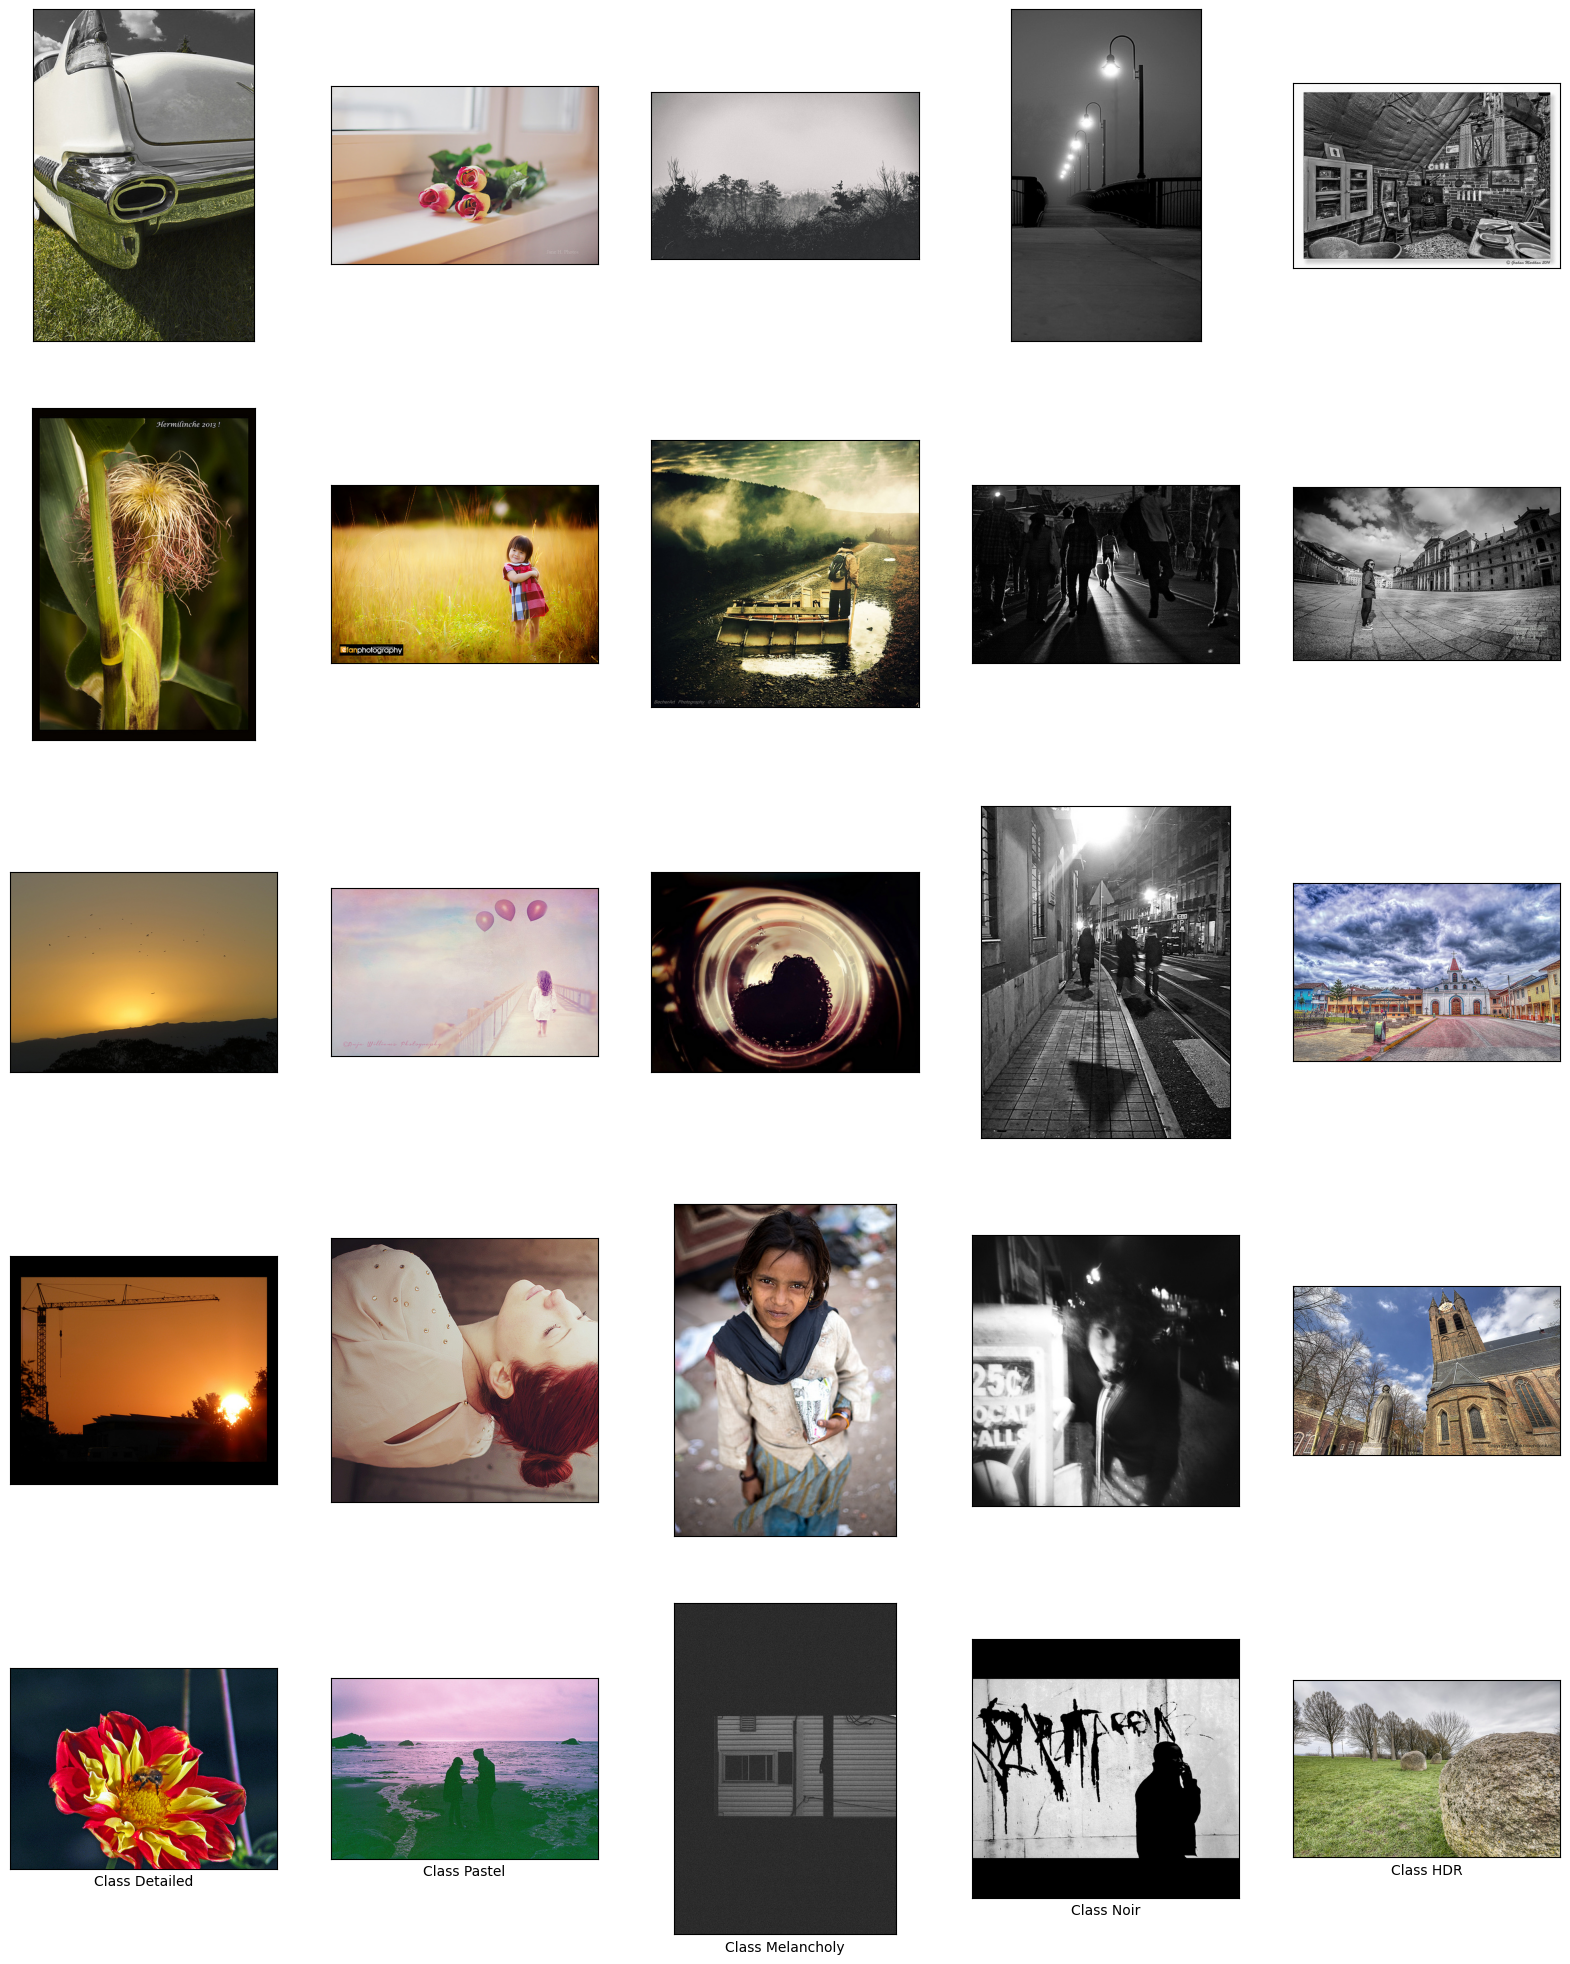

In [ ]:
# Mostramos 5 imágenes de cada clase.
plot_n_images = 5
fig = plt.figure(figsize=(20, 25))

np.random.seed(1000)
for i in range(0,5):
    select_frame = train_frame[train_frame['labels_idx']==i]
    for j in range(0,plot_n_images):
        aux_index = np.random.choice(select_frame.index)
        fig_i=fig.add_subplot(plot_n_images,5,j*5+i+1)
        fig_i.imshow(plt.imread(train_frame['files'][aux_index]))

        fig_i.set_xticks(())
        fig_i.set_yticks(())

    fig_i.set_xlabel('Class %s' % style_labels[i])

<a id="section3"></a>
# <font color="#004D7F" size=5>Red convolucional desde 0</font>


1. Cargar las imágenes
2. Redimensionar todoas las imágenes para tener el mismo tamaño. Usaremos un tamaño de `(150, 150, 3)`.

La función para transformar las imágenes sería la siguientes:

In [ ]:
def load_img(img_path):
    # cargamos y redimensionamos una imágen
    img = tf.keras.utils.load_img(
        img_path,
        target_size=(150, 150, 3)
    )

    # cambiamos el tipo imagen a un numpy.array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # normalizamos los valores entre 0 y 1
    return img_array / 255

In [ ]:
img = load_img('data/flickr_style/images/2216312257_2ba4af8439.jpg')
img[0,0,0]

0.21960784

Ahora vamos a cargar las imágenes para poder entrenar nuestras redes convolucionales:

In [ ]:
# cargamos las imágenes ya transformadas
x_train = np.array([load_img(img_path) for img_path in train_frame['files']])
x_test = np.array([load_img(img_path) for img_path in test_frame['files']])

# cargamos las clases de cada imagen
y_train = train_frame['labels_idx']
y_test = test_frame['labels_idx']

In [ ]:
#Mostramos la clase de y_train, label literal con el cual esta etiquetado
x_train[0,0,0], train_frame['labels'][0]

(array([0.21960784, 0.21960784, 0.22745098], dtype=float32), 'Noir')

In [ ]:
#Consultamos el tamaño del conjunto de datos y dimensiones para traning como para la parte de test.
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print("Clases : ", style_labels)

Train: X=(1385, 150, 150, 3), y=(1385,)
Test: X=(320, 150, 150, 3), y=(320,)
Clases :  ['Detailed', 'Pastel', 'Melancholy', 'Noir', 'HDR']


<a id="section3.1"></a>
### <font color="#004D7F" size=4>Ejercicio 1</font>


Arquitectura de la red:

- Capa convolucional `Conv2D` con 16 filtros/kernels de tamaño `(3,3)`, padding con relleno, activación *ReLU* y con entrada `(150,150,3)`
- Capa pooling `MaxPool2D` con reducción de 2 tanto en tamaño como en desplazamiento (stride) y padding con relleno.
- Capa de aplanado `Flatten`.
- Capa densa `Dense` con 64 neuronas y función de activación _ReLU_.
- Capa densa `Dense` con 32 neuronas y función de activación _ReLU_.
- Capa de salida densa `Dense` con 5 neuronas y función de activación _Softmax_.

Configuración del entrenamiento:

- Optimizador: Adam con factor de entrenamiento 0.001
- Función de error: `sparce_categorical_crossentropy`.
- Métricas: `accuracy`.
- Número de _epochs_: 10
- Validation split: 0.2

In [ ]:
#Modelo 1

model_1 = tf.keras.models.Sequential(name = 'Modelo_1') #Definicion del tipo de modelo
model_1.add(tf.keras.layers.Conv2D(filters = 16, kernel_size= (3,3), padding="same", activation="relu", input_shape=(150,150,3))) #Capa convolucional 2D con 16 filtros, kernels 3x3, con relleno y activacion relu, tamaño de entrada 150x150 de 3 dimensiones
model_1.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same")) #Capa maxPool2D con Reduccion de 2(reduce el tamaño de la imagen a la mitad),  desplazamiento 2x2 y con relleno o padding = 'same'
model_1.add(tf.keras.layers.Flatten()) #Capa flatten la cual transforma los datos en una dimension para ser utilizados por las capas densas
model_1.add(tf.keras.layers.Dense(64, activation= 'relu')) #Capa de oculta con activacion relu (la función ReLU devuelve cero si la entrada es negativa y devuelve la entrada directamente si es positiva.
model_1.add(tf.keras.layers.Dense(32, activation= 'relu' )) #Capa de oculta
model_1.add(tf.keras.layers.Dense(5, activation= 'softmax' )) #Capa de oculta del mismo numero de neurona que la salida y activacion softmax para problema multiclases -
                                                                  #para realizar una distribucion de probablidades entre las clases y la clase con la mayor probabilidad será la predicción

model_1.summary()


Model: "Modelo_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 90000)             0         
                                                                 
 dense (Dense)               (None, 64)                5760064   
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 5)                 165       
                                                          

In [ ]:
#Compilacion de modelo con la definicion del tipo de optimizador a utilizar y funcion de peridda para medir el desempeño del entrenamiento-
#de acuerdo a los ajustes de los pesos por el optimizador.

model_1.compile(optimizer= tf.keras.optimizers.Adam(
    learning_rate= 0.001),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'])

#Entrenamiento con el conjunto de datos de training

modelo_1_hist = model_1.fit(x_train, y_train, validation_split= 0.2, epochs= 10, verbose=0)
print("Modelo Entrenado")

Modelo Entrenado


Evalua el modelo con el conjunto de test y muestra en una gráfica la evolución del entrenamiento:

In [ ]:
#Metrica de Evaluacion del modelo

modelo1 = model_1.evaluate(x_train, y_train, verbose= 0)
print("Training score")
print("Precision: %.2f%%" % (modelo1[1]*100) +" & " + "Error de linea base: %.2f%%" % (100-modelo1[1]*100))

print(" ")

modelo1 = model_1.evaluate(x_test, y_test, verbose = 0)
print("Test score: ")
print("Precision: %.2f%%" % (modelo1[1]*100) +" & " + "Error de linea base: %.2f%%" % (100-modelo1[1]*100))

Training score
Precision: 89.24% & Error de linea base: 10.76%
 
Test score: 
Precision: 46.25% & Error de linea base: 53.75%


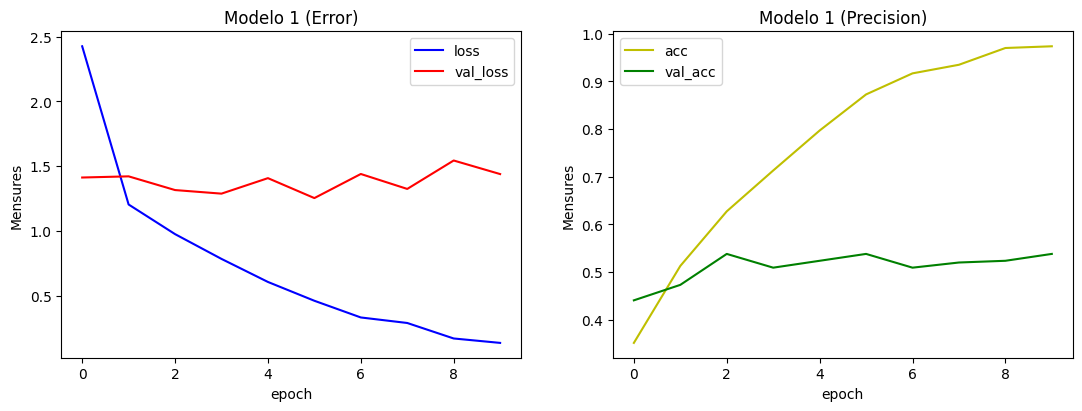

In [ ]:
#Visualizacion del rendimiento (Error y Precision) del modelo

fig=plt.figure(figsize=(70, 50))

fig.add_subplot(10, 10, 1)

plt.plot(modelo_1_hist.history['loss'],'b', label="loss")
plt.plot(modelo_1_hist.history['val_loss'],'r' ,label="val_loss")
plt.ylabel('Mensures')
plt.xlabel('epoch')
plt.legend()
plt.title('Modelo 1 (Error)')

fig.add_subplot(10, 10, 2)

plt.plot(modelo_1_hist.history['accuracy'],'y', label="acc")
plt.plot(modelo_1_hist.history['val_accuracy'],'g' ,label="val_acc")
plt.ylabel('Mensures')
plt.xlabel('epoch')
plt.legend()
plt.title('Modelo 1 (Precision)')


plt.show()

<a id="section3.2"></a>
### <font color="#004D7F" size=4>Ejercicio 2</font>

Arquitectura de la red:

- Capa convolucional `Conv2D` con 64 filtros/kernels de tamaño `(3,3)`, padding con relleno, activación *ReLU* y con entrada `(150,150,3)`
- Capa pooling `MaxPool2D` con reducción de 2 tanto en tamaño como en desplazamiento (stride) y padding con relleno.
- Capa convolucional `Conv2D` con 32 filtros/kernels de tamaño `(3,3)`, padding con relleno, activación *ReLU*
- Capa pooling `MaxPool2D` con reducción de 2 tanto en tamaño como en desplazamiento (stride) y padding con relleno.
- Capa convolucional `Conv2D` con 32 filtros/kernels de tamaño `(3,3)`, padding con relleno, activación *ReLU*
- Capa pooling `MaxPool2D` con reducción de 2 tanto en tamaño como en desplazamiento (stride) y padding con relleno.
- Capa de aplanado `Flatten`.
- Capa densa `Dense` con 64 neuronas y función de activación _ReLU_.
- Capa `Dropout` con un valor de `0.75`.
- Capa densa `Dense` con 32 neuronas y función de activación _ReLU_.
- Capa densa `Dense` con 32 neuronas y función de activación _ReLU_.
- Capa `Dropout` con un valor de `0.6`.
- Capa de salida densa `Dense` con 10 neuronas y función de activación _Softmax_.

Configuración del entrenamiento:

- Optimizador: Adam con factor de entrenamiento 0.001
- Función de error: `sparce_categorical_crossentropy`.
- Métricas: `accuracy`.
- Número de _epochs_: 50
- Validation split: 0.2

In [ ]:
#Modelo 2

model_2 = tf.keras.models.Sequential(name = 'Modelo_2')
model_2.add(tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), padding="same", activation="relu", input_shape=(150,150,3)))
model_2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
model_2.add(tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding="same", activation="relu"))
model_2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
model_2.add(tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding="same", activation="relu"))
model_2.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding="same"))
model_2.add(tf.keras.layers.Flatten())
model_2.add(tf.keras.layers.Dense(64, activation= 'relu'))
model_2.add(tf.keras.layers.Dropout(0.75))
model_2.add(tf.keras.layers.Dense(32, activation= 'relu'))
model_2.add(tf.keras.layers.Dense(32, activation= 'relu'))
model_2.add(tf.keras.layers.Dropout(0.60))
model_2.add(tf.keras.layers.Dense(10, activation= 'softmax' ))

model_2.summary()

Model: "Modelo_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 75, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 38, 38, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 38, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 19, 19, 32)       0  

In [ ]:
#Compilacion de modelo con la definicion del tipo de optimizador a utilizar y funcion de peridda para medir el desempeño del entrenamiento-
#de acuerdo a los ajustes de los pesos por el optimizador.

model_2.compile(optimizer= tf.keras.optimizers.Adam(
    learning_rate= 0.001),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'])

#Entrenamiento con el conjunto de datos de training

modelo_2_hist = model_2.fit(x_train, y_train, validation_split= 0.2, epochs= 50, verbose=0)
print("Modelo Entrenado")

Modelo Entrenado


Evalua el modelo con el conjunto de test y muestra en una gráfica la evolución del entrenamiento:

In [ ]:
modelo2 = model_2.evaluate(x_train, y_train, verbose= 0)
print("Training score")
print("Precision: %.2f%%" % (modelo2[1]*100) +" & " + "Error de linea base: %.2f%%" % (100-modelo2[1]*100))

print(" ")

modelo2 = model_2.evaluate(x_test, y_test, verbose = 0)
print("Test score: ")
print("Precision: %.2f%%" % (modelo2[1]*100) +" & " + "Error de linea base: %.2f%%" % (100-modelo2[1]*100))

Training score
Precision: 67.15% & Error de linea base: 32.85%
 
Test score: 
Precision: 35.94% & Error de linea base: 64.06%


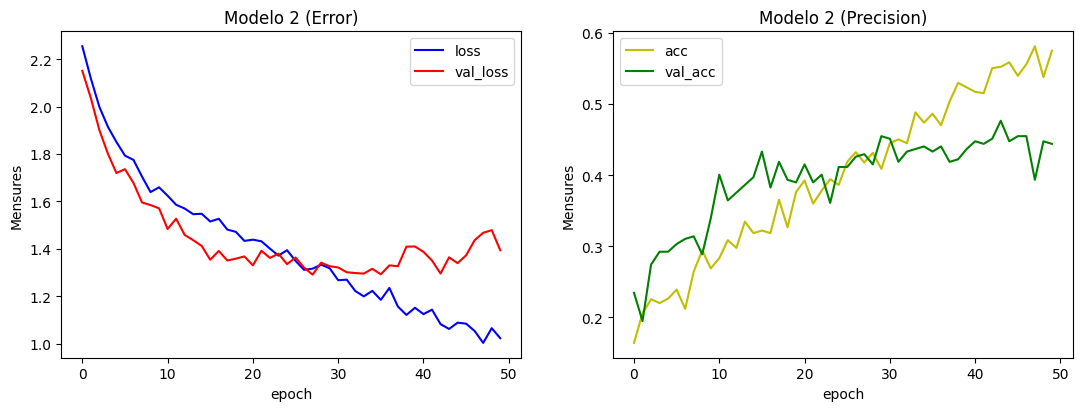

In [ ]:
#Visualizacion del rendimiento (Error y Precision) del modelo

fig=plt.figure(figsize=(70, 50))

fig.add_subplot(10, 10, 1)

plt.plot(modelo_2_hist.history['loss'],'b', label="loss")
plt.plot(modelo_2_hist.history['val_loss'],'r' ,label="val_loss")
plt.ylabel('Mensures')
plt.xlabel('epoch')
plt.legend()
plt.title('Modelo 2 (Error)')

fig.add_subplot(10, 10, 2)

plt.plot(modelo_2_hist.history['accuracy'],'y', label="acc")
plt.plot(modelo_2_hist.history['val_accuracy'],'g' ,label="val_acc")
plt.ylabel('Mensures')
plt.xlabel('epoch')
plt.legend()
plt.title('Modelo 2 (Precision)')


plt.show()



Podemos observar que el primer modelo tuvo una mejor convergecia, sin embargo, muestra un overfitting significativo por lo que el modelo no seria capaz de generalizar bien con nuevos datos, su aprendizaje esta muy sesgado por lo datos de entrenamiento, en el mismo orden con el modelo 2 observamos ruido tanto en el entrenamiento como en los datos de validacion, y con una precision mas baja que el modelo 1 podemos deducir que el modelo no tiene un buen rendimiento solo seria capaza de predecir un 35% aproximadamente, seria mejor, optimizar las arquitectura del modelo 1.

<a id="section4"></a>
# <font color="#004D7F" size=5>Red pre-entrenada (InceptionV3)</font>

Ahora vamos a realizar experimento usando la técnica de _fine-tuning_ y utilizando el modelo pre-entrenado de [_InceptionV3_](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3).


<a id="section4.1"></a>
## <font color="#004D7F" size=4>Ejercicio 3: preprocesamiento de las imágenes</font>
Como vamos a usar un modelo pre-entreando tenemos que definir la función que nos transforme las imágenes a utilizar.  para utilizar las imágenes usando un modelo pre-entrenado es necesario realizar una transformación sobre las imágenes que vamos a utilizar, es decir, tenemos que:

1. Cargar las imágenes
2. Redimensionarlas
3. Usar la función de `preprocess_input` del modelo pre-entrenado que vamos a utilizar.



In [ ]:
def load_img_inceptionv3(img_path):
  # cargamos y redimensionamos una imágen
    img = tf.keras.utils.load_img(
          img_path,
          target_size=(299,299,3)
     )
     # cambiamos el tipo imagen a un numpy.array
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    # aplicamos la función preprocess_input de inceptionv3
    return tf.keras.applications.inception_v3.preprocess_input(img_array)

In [ ]:
img = load_img_inceptionv3('data/flickr_style/images/2216312257_2ba4af8439.jpg')
img[0,0,0]

-0.5529412

<a id="section4.2"></a>
## <font color="#004D7F" size=4>Ejercicio 4: aplicar el preprocesamiento a todas las imágenes</font>
Una vez tenemos definida nuestra función de para transformar las imágenes, aplíca la transformación tanto al conjunto de train como al conjunto de test como hemos visto en clase.

In [ ]:
# cargamos las imágenes ya transformadas
x_train = np.array([load_img_inceptionv3(img_path) for img_path in train_frame['files']])
x_test = np.array([load_img_inceptionv3(img_path) for img_path in test_frame['files']])

# cargamos las clases de cada imagen
y_train = train_frame['labels_idx']
y_test = test_frame['labels_idx']

In [ ]:
x_train[0,0,0], y_train[0]

(array([-0.5529412, -0.5529412, -0.5372549], dtype=float32), 3)

In [ ]:
#Mostramos la clase de y_train, label literal con el cual esta etiquetado
x_train[0,0,0], train_frame['labels'][0]

(array([-0.5529412, -0.5529412, -0.5372549], dtype=float32), 'Noir')

In [ ]:
x_train.shape

(1385, 299, 299, 3)

<a id="section4.3"></a>
## <font color="#004D7F" size=4>Ejercicio 5: cargar el modelo pre-entrenado InceptionV3</font>
Una vez tenemos los datos listos, vamos a cargar el modelo pre-entrenado de [_InceptionV3_](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/InceptionV3).

Como vamos a aplicar _fine-tuning_ recuerda usar los siguientes parámetros:
- `input_shape=(299, 299, 3)`
- `include_top=False`
- `pooling='avg'`

Congelar todas las capas para que no se entrenen todas, solo queremos entrenar las últimas.

In [ ]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(299,299,3),
    pooling='avg'
)

In [ ]:
base_model.layers[-2:]

In [ ]:
#Resumen de los parametros donde podemos observar que 21.76 k de 21.80 k son entrenables.

total_params = base_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in base_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in base_model.non_trainable_weights])

print(f"Total Parametros:  {total_params:,.0f}")
print(f"Parametros Entrenable:  {trainable_params:,.0f}")
print(f"Parametros No Entrenable:  {non_trainable_params:,.0f}")

Total Parametros:  21,802,784
Parametros Entrenable:  21,768,352
Parametros No Entrenable:  34,432


**Congelar todas las capas para que no se entrenen todas, ya que solo queremos entrenar las últimas que añadamos nosotros.**

In [ ]:
# Congelamos el entrenamiento en todas las capas y mostramos el resumen de los parametros para validar que ningun parametros es entrenable.
for layer in base_model.layers:
    layer.trainable = False

total_params = base_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in base_model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in base_model.non_trainable_weights])

print(f"Total Parametros:  {total_params:,.0f}")
print(f"Parametros Entrenable:  {trainable_params:,.0f}")
print(f"Parametros no Entrenables:  {non_trainable_params:,.0f}")

Total Parametros:  21,802,784
Parametros Entrenable:  0
Parametros no Entrenables:  21,802,784


In [ ]:
# Accedemos a la última capa del modelo
base_model.output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'global_average_pooling2d')>

<a id="section4.4"></a>
## <font color="#004D7F" size=4>Ejercicio 6: añadir capas al modelo (_fine-tuning_)</font>
Una vez tenemos nuestro modelo base, vamos a añadir capas densas al final para entrenarlas y que el modelo se ajuste a nuestros datos.

- Capa Dropout con un valor de 0.60.
- Capa Densa de 128 neuronas y función de activación `relu`.
- Capa Dropout con un valor de 0.4.
- Capa Densa de salida con 5 neuronas y función de activación `softmax`.

In [ ]:
x1 = tf.keras.layers.Dropout(0.60)(base_model.output)
x2 = tf.keras.layers.Dense(128, activation='relu')(x1)
x3 = tf.keras.layers.Dropout(0.4)(x2)
Z = tf.keras.layers.Dense(5, activation='softmax', name='my_layer')(x3)

model = tf.keras.Model(base_model.input, Z)

In [ ]:
model.layers[-4:]

<a id="section4.5"></a>
## <font color="#004D7F" size=4>Ejercicio 7: entrenar el modelo</font>
Una vez tenemos nuestro modelo listo para entrenar, vamos a configurar el entrenamiento y a entrenar nuesto modelo.

El entrenamiento utiliza:
- Optimizador: Adam con learning rate de 0.001.
- Función de coste: `sparse_categorical_crossentropy`.
- Métricas: `accuracy`.
- Epochs: `25`
- validation_split: 0.2

In [ ]:
#Compilacion del modelo con la definicion del tipo de optimizador a utilizar y funcion de peridda para medir el desempeño del entrenamiento-
#de acuerdo a los ajustes de los pesos por el optimizador.
model.compile(optimizer= tf.keras.optimizers.Adam(
    learning_rate= 0.001),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'])

#Entrenamiento con el conjunto de datos de training

model_hist = model.fit(x_train, y_train, validation_split = 0.2, epochs= 25, verbose=0)
print("Modelo Entrenado")

Modelo Entrenado


<a id="section4.6"></a>
## <font color="#004D7F" size=4>Ejercicio 8: evaluar el modelo</font>


In [ ]:
#Metrica de Evaluacion del modelo

modelo1 = model.evaluate(x_train, y_train, verbose= 0)
print("Training score")
print("Precision: %.2f%%" % (modelo1[1]*100) +" & " + "Error de linea base: %.2f%%" % (100-modelo1[1]*100))

print(" ")

modelo1 = model.evaluate(x_test, y_test, verbose = 0)
print("Test score: ")
print("Precision: %.2f%%" % (modelo1[1]*100) +" & " + "Error de linea base: %.2f%%" % (100-modelo1[1]*100))

Training score
Precision: 81.95% & Error de linea base: 18.05%
 
Test score: 
Precision: 54.69% & Error de linea base: 45.31%


**CONCLUSIONES**

Podemos observar que el modelo presenta un rendimento no muy bueno, hay una discrepancia significativa entre la precision del entrenamiento y los datos de pruebas por lo que podemos concluir que el modelo no generaliza bien, sin embargo, en comparacion con los modelos anteriores tiene mejor rendimiento en especial con los datos de nuevos el modelo 1 tiene una precision de 46% mientras este modelo presenta 55%. ademas de esto podemos notar que el modelo muestra un sobreajuste, algunas recomendaciones son bajar el learning rate y aumentar las Epoch para que converga mejor o utilizar la tecnica de Batch, por otro lado para mitigar el sobre ajuste que presenta y el cual puede presentar al cambiar las configuraciones anteriores usar otra capa Dropout, lo primero que haria es pruebar con diferentes Size Batch y Dropout.

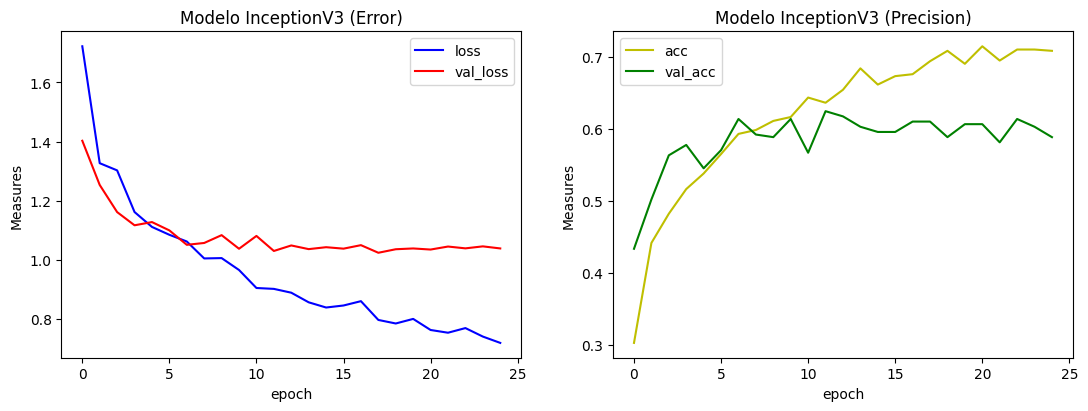

In [ ]:
#Visualizacion del rendimiento (Error y Precision) del modelo

fig=plt.figure(figsize=(70, 50))

fig.add_subplot(10, 10, 1)

plt.plot(model_hist.history['loss'],'b', label="loss")
plt.plot(model_hist.history['val_loss'],'r' ,label="val_loss")
plt.ylabel('Measures')
plt.xlabel('epoch')
plt.legend()
plt.title('Modelo InceptionV3 (Error)')

fig.add_subplot(10, 10, 2)

plt.plot(model_hist.history['accuracy'],'y', label="acc")
plt.plot(model_hist.history['val_accuracy'],'g' ,label="val_acc")
plt.ylabel('Measures')
plt.xlabel('epoch')
plt.legend()
plt.title('Modelo InceptionV3 (Precision)')


plt.show()



<a id="section5.1"></a>
## <font color="#004D7F" size=4>Ejercicio 7</font>



In [ ]:
x1 = tf.keras.layers.Dropout(0.5)(base_model.output)
x2 = tf.keras.layers.Dense(128, activation='relu')(x1)
x3 = tf.keras.layers.Dropout(0.4)(x2)
x4 = tf.keras.layers.Dense(64, activation='relu')(x3)
x5 = tf.keras.layers.Dropout(0.4)(x4)
Z = tf.keras.layers.Dense(5, activation='softmax', name='my_layer')(x5)

model_f = tf.keras.Model(base_model.input, Z)

In [ ]:
#Compilacion del modelo con la definicion del tipo de optimizador a utilizar y funcion de peridda para medir el desempeño del entrenamiento-
#de acuerdo a los ajustes de los pesos por el optimizador.
model_f.compile(optimizer= tf.keras.optimizers.Adam(
    learning_rate= 0.001),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'])

#Entrenamiento con el conjunto de datos de training

model_hist_f = model_f.fit(x_train, y_train, validation_split = 0.2, epochs= 50, batch_size= 256, verbose=0)
print("Modelo Entrenado")

Modelo Entrenado


In [ ]:
#Metrica de Evaluacion del modelo

modelof = model_f.evaluate(x_train, y_train, verbose= 0)
print("Training score")
print("Precision: %.2f%%" % (modelof[1]*100) +" & " + "Error de linea base: %.2f%%" % (100-modelof[1]*100))

print(" ")

modelof = model_f.evaluate(x_test, y_test, verbose = 0)
print("Test score: ")
print("Precision: %.2f%%" % (modelof[1]*100) +" & " + "Error de linea base: %.2f%%" % (100-modelof[1]*100))

Training score
Precision: 72.64% & Error de linea base: 27.36%
 
Test score: 
Precision: 59.69% & Error de linea base: 40.31%


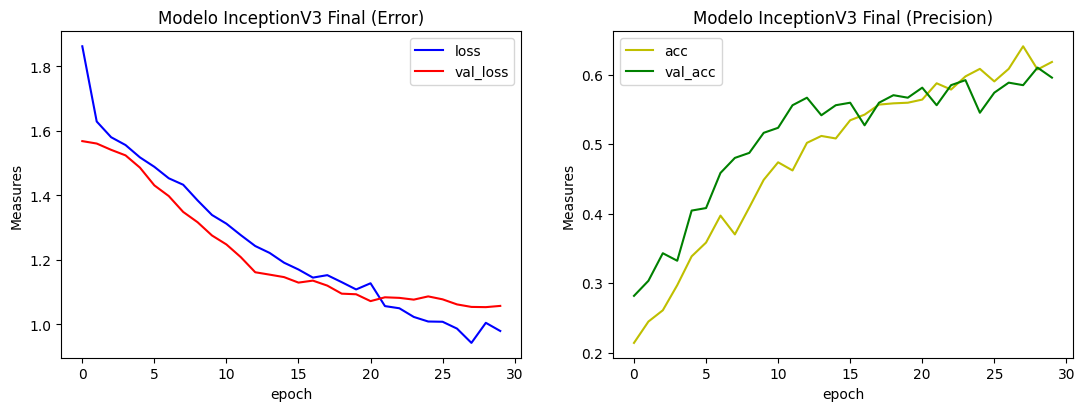

In [ ]:
#Visualizacion del rendimiento (Error y Precision) del modelo

fig=plt.figure(figsize=(70, 50))

fig.add_subplot(10, 10, 1)

plt.plot(model_hist_f.history['loss'],'b', label="loss")
plt.plot(model_hist_f.history['val_loss'],'r' ,label="val_loss")
plt.ylabel('Measures')
plt.xlabel('epoch')
plt.legend()
plt.title('Modelo InceptionV3 Final (Error)')

fig.add_subplot(10, 10, 2)

plt.plot(model_hist_f.history['accuracy'],'y', label="acc")
plt.plot(model_hist_f.history['val_accuracy'],'g' ,label="val_acc")
plt.ylabel('Measures')
plt.xlabel('epoch')
plt.legend()
plt.title('Modelo InceptionV3 Final (Precision)')


plt.show()

<a id="section6"></a>
# <font color="#004D7F" size=5>¿Cuál es el mejor modelo?</font>



Luego de terminar cada experimento podemos notar en las evaluaciones que el modelo 1 y el modelo 2 donde se crearon modelos desde cero el modelo 1 obtuvo mejor rendimiento,  no obtante, no es un resultado aceptable, ahora esta comparativa de modelo 1 se realizo con el modelo fine-tuning Inception v3 el cual resulto con un mejor rendimiento especialmente en la evaluacion de la precision con datos nuevos, sin embargo, esta arquitectura presentaba overfitting, por lo cual concluimos con unas recomendaciones para obtener una mejor convergencia del entrenamiento, mitigar el overfiting y conseguir una mejor precision.

Estas recomendaciones fueron experimentada en la parte opconal de proyecto donde podemos observar que el modelo tuvo un resultado positivo y aceptable con respecto a los demas modelos con un precision en los datos de evaluacion que fueron evolucionando desde:

*   modelo 1: 46 %
*   modelo Incerption: 55%
*   modelo final con 60%


 En precision con la validacion de los datos nuevos y sin sobre ajuste para el modelo final.

A partir de estos resultados, el modelo que optaria por selecionar para poner en produccion sera el modelo Final ya que el mismo presenta un resultado y rendimiento aceptable para un modelo de clasificacion de imagenes y ya que la misma clasificacion no es de tema sensible para una toma de desicion tan importante como para afectar la integridad de una persona.